In [3]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd


Either run this cell and replace all the missing data with NAN

In [4]:
data = pd.read_csv("./diabetic_data.csv")
data.replace('?',np.nan,inplace=True)

or run the following two cells for a different data preprocessing

In [ ]:
data = pd.read_csv("./diabetic_data.csv")
data["race_age_gender"] = data["race"].map(str) + data["gender"].map(str) + data["age"].map(str)
data["num_medications" + "_log"] = np.log(data["num_medications"])

In [ ]:
drop_Idx = set(data[(data['diag_1'] == '?') & (data['diag_2'] == '?') & (data['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(data['diag_1'][data['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(data['diag_2'][data['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(data['diag_3'][data['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(data['race'][data['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(data[data['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(data['gender'][data['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(data.index) - set(drop_Idx))
data = data.iloc[new_Idx]

In [ ]:
# re-encoding admission type, discharge type and admission source into fewer categories

data['admission_type_id'] = data['admission_type_id'].replace(2,1)
data['admission_type_id'] = data['admission_type_id'].replace(7,1)
data['admission_type_id'] = data['admission_type_id'].replace(6,5)
data['admission_type_id'] = data['admission_type_id'].replace(8,5)

data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(6,1)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(8,1)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(9,1)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(13,1)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(3,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(4,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(5,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(14,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(22,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(23,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(24,2)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(12,10)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(15,10)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(16,10)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(17,10)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(25,18)
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace(26,18)

data['admission_source_id'] = data['admission_source_id'].replace(2,1)
data['admission_source_id'] = data['admission_source_id'].replace(3,1)
data['admission_source_id'] = data['admission_source_id'].replace(5,4)
data['admission_source_id'] = data['admission_source_id'].replace(6,4)
data['admission_source_id'] = data['admission_source_id'].replace(10,4)
data['admission_source_id'] = data['admission_source_id'].replace(22,4)
data['admission_source_id'] = data['admission_source_id'].replace(25,4)
data['admission_source_id'] = data['admission_source_id'].replace(15,9)
data['admission_source_id'] = data['admission_source_id'].replace(17,9)
data['admission_source_id'] = data['admission_source_id'].replace(20,9)
data['admission_source_id'] = data['admission_source_id'].replace(21,9)
data['admission_source_id'] = data['admission_source_id'].replace(13,11)
data['admission_source_id'] = data['admission_source_id'].replace(14,11)


data['A1Cresult'] = data['A1Cresult'].replace('>7', 1)
data['A1Cresult'] = data['A1Cresult'].replace('>8', 1)
data['A1Cresult'] = data['A1Cresult'].replace('Norm', 0)
data['A1Cresult'] = data['A1Cresult'].replace('None', -99)
data['max_glu_serum'] = data['max_glu_serum'].replace('>200', 1)
data['max_glu_serum'] = data['max_glu_serum'].replace('>300', 1)
data['max_glu_serum'] = data['max_glu_serum'].replace('Norm', 0)
data['max_glu_serum'] = data['max_glu_serum'].replace('None', -99)


data['level1_diag1'] = data['diag_1']
data['level2_diag1'] = data['diag_1']
data['level1_diag2'] = data['diag_2']
data['level2_diag2'] = data['diag_2']
data['level1_diag3'] = data['diag_3']
data['level2_diag3'] = data['diag_3']

data.loc[data['diag_1'].str.contains('V'), ['level1_diag1', 'level2_diag1']] = 0
data.loc[data['diag_1'].str.contains('E'), ['level1_diag1', 'level2_diag1']] = 0
data.loc[data['diag_2'].str.contains('V'), ['level1_diag2', 'level2_diag2']] = 0
data.loc[data['diag_2'].str.contains('E'), ['level1_diag2', 'level2_diag2']] = 0
data.loc[data['diag_3'].str.contains('V'), ['level1_diag3', 'level2_diag3']] = 0
data.loc[data['diag_3'].str.contains('E'), ['level1_diag3', 'level2_diag3']] = 0
data['level1_diag1'] = data['level1_diag1'].replace('?', -1)
data['level2_diag1'] = data['level2_diag1'].replace('?', -1)
data['level1_diag2'] = data['level1_diag2'].replace('?', -1)
data['level2_diag2'] = data['level2_diag2'].replace('?', -1)
data['level1_diag3'] = data['level1_diag3'].replace('?', -1)
data['level2_diag3'] = data['level2_diag3'].replace('?', -1)

data['level1_diag1'] = data['level1_diag1'].astype(float)
data['level2_diag1'] = data['level2_diag1'].astype(float)
data['level1_diag2'] = data['level1_diag2'].astype(float)
data['level2_diag2'] = data['level2_diag2'].astype(float)
data['level1_diag3'] = data['level1_diag3'].astype(float)
data['level2_diag3'] = data['level2_diag3'].astype(float)


for index, row in data.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        data.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        data.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        data.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        data.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        data.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        data.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        data.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        data.loc[index, 'level1_diag1'] = 8
    else:
        data.loc[index, 'level1_diag1'] = 0
        
    if (row['level1_diag2'] >= 390 and row['level1_diag2'] < 460) or (np.floor(row['level1_diag2']) == 785):
        data.loc[index, 'level1_diag2'] = 1
    elif (row['level1_diag2'] >= 460 and row['level1_diag2'] < 520) or (np.floor(row['level1_diag2']) == 786):
        data.loc[index, 'level1_diag2'] = 2
    elif (row['level1_diag2'] >= 520 and row['level1_diag2'] < 580) or (np.floor(row['level1_diag2']) == 787):
        data.loc[index, 'level1_diag2'] = 3
    elif (np.floor(row['level1_diag2']) == 250):
        data.loc[index, 'level1_diag2'] = 4
    elif (row['level1_diag2'] >= 800 and row['level1_diag2'] < 1000):
        data.loc[index, 'level1_diag2'] = 5
    elif (row['level1_diag2'] >= 710 and row['level1_diag2'] < 740):
        data.loc[index, 'level1_diag2'] = 6
    elif (row['level1_diag2'] >= 580 and row['level1_diag2'] < 630) or (np.floor(row['level1_diag2']) == 788):
        data.loc[index, 'level1_diag2'] = 7
    elif (row['level1_diag2'] >= 140 and row['level1_diag2'] < 240):
        data.loc[index, 'level1_diag2'] = 8
    else:
        data.loc[index, 'level1_diag2'] = 0
    
    if (row['level1_diag3'] >= 390 and row['level1_diag3'] < 460) or (np.floor(row['level1_diag3']) == 785):
        data.loc[index, 'level1_diag3'] = 1
    elif (row['level1_diag3'] >= 460 and row['level1_diag3'] < 520) or (np.floor(row['level1_diag3']) == 786):
        data.loc[index, 'level1_diag3'] = 2
    elif (row['level1_diag3'] >= 520 and row['level1_diag3'] < 580) or (np.floor(row['level1_diag3']) == 787):
        data.loc[index, 'level1_diag3'] = 3
    elif (np.floor(row['level1_diag3']) == 250):
        data.loc[index, 'level1_diag3'] = 4
    elif (row['level1_diag3'] >= 800 and row['level1_diag3'] < 1000):
        data.loc[index, 'level1_diag3'] = 5
    elif (row['level1_diag3'] >= 710 and row['level1_diag3'] < 740):
        data.loc[index, 'level1_diag3'] = 6
    elif (row['level1_diag3'] >= 580 and row['level1_diag3'] < 630) or (np.floor(row['level1_diag3']) == 788):
        data.loc[index, 'level1_diag3'] = 7
    elif (row['level1_diag3'] >= 140 and row['level1_diag3'] <
          240):
        data.loc[index, 'level1_diag3'] = 8
    else:
        data.loc[index, 'level1_diag3'] = 0
        

for index, row in data.iterrows():
    if (row['level2_diag1'] >= 390 and row['level2_diag1'] < 399):
        data.loc[index, 'level2_diag1'] = 1
    elif (row['level2_diag1'] >= 401 and row['level2_diag1'] < 415):
        data.loc[index, 'level2_diag1'] = 2
    elif (row['level2_diag1'] >= 415 and row['level2_diag1'] < 460):
        data.loc[index, 'level2_diag1'] = 3
    elif (np.floor(row['level2_diag1']) == 785):
        data.loc[index, 'level2_diag1'] = 4
    elif (row['level2_diag1'] >= 460 and row['level2_diag1'] < 489):
        data.loc[index, 'level2_diag1'] = 5
    elif (row['level2_diag1'] >= 490 and row['level2_diag1'] < 497):
        data.loc[index, 'level2_diag1'] = 6
    elif (row['level2_diag1'] >= 500 and row['level2_diag1'] < 520):
        data.loc[index, 'level2_diag1'] = 7
    elif (np.floor(row['level2_diag1']) == 786):
        data.loc[index, 'level2_diag1'] = 8
    elif (row['level2_diag1'] >= 520 and row['level2_diag1'] < 530):
        data.loc[index, 'level2_diag1'] = 9
    elif (row['level2_diag1'] >= 530 and row['level2_diag1'] < 544):
        data.loc[index, 'level2_diag1'] = 10
    elif (row['level2_diag1'] >= 550 and row['level2_diag1'] < 554):
        data.loc[index, 'level2_diag1'] = 11
    elif (row['level2_diag1'] >= 555 and row['level2_diag1'] < 580):
        data.loc[index, 'level2_diag1'] = 12
    elif (np.floor(row['level2_diag1']) == 787):
        data.loc[index, 'level2_diag1'] = 13
    elif (np.floor(row['level2_diag1']) == 250):
        data.loc[index, 'level2_diag1'] = 14
    elif (row['level2_diag1'] >= 800 and row['level2_diag1'] < 1000):
        data.loc[index, 'level2_diag1'] = 15
    elif (row['level2_diag1'] >= 710 and row['level2_diag1'] < 740):
        data.loc[index, 'level2_diag1'] = 16
    elif (row['level2_diag1'] >= 580 and row['level2_diag1'] < 630):
        data.loc[index, 'level2_diag1'] = 17
    elif (np.floor(row['level2_diag1']) == 788):
        data.loc[index, 'level2_diag1'] = 18
    elif (row['level2_diag1'] >= 140 and row['level2_diag1'] < 240):
        data.loc[index, 'level2_diag1'] = 19
    elif row['level2_diag1'] >= 240 and row['level2_diag1'] < 280 and (np.floor(row['level2_diag1']) != 250):
        data.loc[index, 'level2_diag1'] = 20
    elif (row['level2_diag1'] >= 680 and row['level2_diag1'] < 710) or (np.floor(row['level2_diag1']) == 782):
        data.loc[index, 'level2_diag1'] = 21
    elif (row['level2_diag1'] >= 290 and row['level2_diag1'] < 320):
        data.loc[index, 'level2_diag1'] = 22
    else:
        data.loc[index, 'level2_diag1'] = 0
        
    if (row['level2_diag2'] >= 390 and row['level2_diag2'] < 399):
        data.loc[index, 'level2_diag2'] = 1
    elif (row['level2_diag2'] >= 401 and row['level2_diag2'] < 415):
        data.loc[index, 'level2_diag2'] = 2
    elif (row['level2_diag2'] >= 415 and row['level2_diag2'] < 460):
        data.loc[index, 'level2_diag2'] = 3
    elif (np.floor(row['level2_diag2']) == 785):
        data.loc[index, 'level2_diag2'] = 4
    elif (row['level2_diag2'] >= 460 and row['level2_diag2'] < 489):
        data.loc[index, 'level2_diag2'] = 5
    elif (row['level2_diag2'] >= 490 and row['level2_diag2'] < 497):
        data.loc[index, 'level2_diag2'] = 6
    elif (row['level2_diag2'] >= 500 and row['level2_diag2'] < 520):
        data.loc[index, 'level2_diag2'] = 7
    elif (np.floor(row['level2_diag2']) == 786):
        data.loc[index, 'level2_diag2'] = 8
    elif (row['level2_diag2'] >= 520 and row['level2_diag2'] < 530):
        data.loc[index, 'level2_diag2'] = 9
    elif (row['level2_diag2'] >= 530 and row['level2_diag2'] < 544):
        data.loc[index, 'level2_diag2'] = 10
    elif (row['level2_diag2'] >= 550 and row['level2_diag2'] < 554):
        data.loc[index, 'level2_diag2'] = 11
    elif (row['level2_diag2'] >= 555 and row['level2_diag2'] < 580):
        data.loc[index, 'level2_diag2'] = 12
    elif (np.floor(row['level2_diag2']) == 787):
        data.loc[index, 'level2_diag2'] = 13
    elif (np.floor(row['level2_diag2']) == 250):
        data.loc[index, 'level2_diag2'] = 14
    elif (row['level2_diag2'] >= 800 and row['level2_diag2'] < 1000):
        data.loc[index, 'level2_diag2'] = 15
    elif (row['level2_diag2'] >= 710 and row['level2_diag2'] < 740):
        data.loc[index, 'level2_diag2'] = 16
    elif (row['level2_diag2'] >= 580 and row['level2_diag2'] < 630):
        data.loc[index, 'level2_diag2'] = 17
    elif (np.floor(row['level2_diag2']) == 788):
        data.loc[index, 'level2_diag2'] = 18
    elif (row['level2_diag2'] >= 140 and row['level2_diag2'] < 240):
        data.loc[index, 'level2_diag2'] = 19
    elif row['level2_diag2'] >= 240 and row['level2_diag2'] < 280 and (np.floor(row['level2_diag2']) != 250):
        data.loc[index, 'level2_diag2'] = 20
    elif (row['level2_diag2'] >= 680 and row['level2_diag2'] < 710) or (np.floor(row['level2_diag2']) == 782):
        data.loc[index, 'level2_diag2'] = 21
    elif (row['level2_diag2'] >= 290 and row['level2_diag2'] < 320):
        data.loc[index, 'level2_diag2'] = 22
    else:
        data.loc[index, 'level2_diag2'] = 0
        
        
    if (row['level2_diag3'] >= 390 and row['level2_diag3'] < 399):
        data.loc[index, 'level2_diag3'] = 1
    elif (row['level2_diag3'] >= 401 and row['level2_diag3'] < 415):
        data.loc[index, 'level2_diag3'] = 2
    elif (row['level2_diag3'] >= 415 and row['level2_diag3'] < 460):
        data.loc[index, 'level2_diag3'] = 3
    elif (np.floor(row['level2_diag3']) == 785):
        data.loc[index, 'level2_diag3'] = 4
    elif (row['level2_diag3'] >= 460 and row['level2_diag3'] < 489):
        data.loc[index, 'level2_diag3'] = 5
    elif (row['level2_diag3'] >= 490 and row['level2_diag3'] < 497):
        data.loc[index, 'level2_diag3'] = 6
    elif (row['level2_diag3'] >= 500 and row['level2_diag3'] < 520):
        data.loc[index, 'level2_diag3'] = 7
    elif (np.floor(row['level2_diag3']) == 786):
        data.loc[index, 'level2_diag3'] = 8
    elif (row['level2_diag3'] >= 520 and row['level2_diag3'] < 530):
        data.loc[index, 'level2_diag3'] = 9
    elif (row['level2_diag3'] >= 530 and row['level2_diag3'] < 544):
        data.loc[index, 'level2_diag3'] = 10
    elif (row['level2_diag3'] >= 550 and row['level2_diag3'] < 554):
        data.loc[index, 'level2_diag3'] = 11
    elif (row['level2_diag3'] >= 555 and row['level2_diag3'] < 580):
        data.loc[index, 'level2_diag3'] = 12
    elif (np.floor(row['level2_diag3']) == 787):
        data.loc[index, 'level2_diag3'] = 13
    elif (np.floor(row['level2_diag3']) == 250):
        data.loc[index, 'level2_diag3'] = 14
    elif (row['level2_diag3'] >= 800 and row['level2_diag3'] < 1000):
        data.loc[index, 'level2_diag3'] = 15
    elif (row['level2_diag3'] >= 710 and row['level2_diag3'] < 740):
        data.loc[index, 'level2_diag3'] = 16
    elif (row['level2_diag3'] >= 580 and row['level2_diag3'] < 630):
        data.loc[index, 'level2_diag3'] = 17
    elif (np.floor(row['level2_diag3']) == 788):
        data.loc[index, 'level2_diag3'] = 18
    elif (row['level2_diag3'] >= 140 and row['level2_diag3'] < 240):
        data.loc[index, 'level2_diag3'] = 19
    elif row['level2_diag3'] >= 240 and row['level2_diag3'] < 280 and (np.floor(row['level2_diag3']) != 250):
        data.loc[index, 'level2_diag3'] = 20
    elif (row['level2_diag3'] >= 680 and row['level2_diag3'] < 710) or (np.floor(row['level2_diag3']) == 782):
        data.loc[index, 'level2_diag3'] = 21
    elif (row['level2_diag3'] >= 290 and row['level2_diag3'] < 320):
        data.loc[index, 'level2_diag3'] = 22
    else:
        data.loc[index, 'level2_diag3'] = 0


In [3]:
from math import log10
class ExploratoryDataAnalysis:
    def __init__(self,data):
        self.data = data
    
    def get_feature_class_count(self,col):
        count_map = {}
        for x in col:
            if(x in count_map):
                count_map[x] = count_map[x] + 1
            else:
                count_map[x] = 1

        return log10(len(count_map))
    
    def get_missing_counts(self,col):
        return len(col) - col.count()
    
    def plot_class_counts(self,plot_missing_feature_count = False):
        class_counts = [self.get_feature_class_count(self.data[column]) for column in self.data]
        data = [go.Histogram(x=self.data.columns, y=class_counts)]
        trace = go.Bar(
            x=self.data.columns,
            y=class_counts
        )
        layout = go.Layout(
            title='Feature counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace], layout=layout))
    
    def plot_class_count(self):
        count_NO = 0
        count_less_30 = 0
        for x in self.data["readmitted"]:
            if(x == "NO"):
                count_NO = count_NO + 1
            elif (x == "<30"):
                count_less_30 = count_less_30 + 1

        trace = go.Bar(
            x=[">30","<30","NO"],
            y=[(len(self.data) - count_NO  - count_less_30),count_less_30,count_NO]
        )
        layout = go.Layout(
            title='Class counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace], layout=layout))
        
    def plot_missing_count(self):
        class_counts = [len(self.data[column]) for column in self.data]
        missing_counts = [self.get_missing_counts(self.data[column]) for column in self.data]
        data = [go.Histogram(x=self.data.columns, y=class_counts)]
        trace = go.Bar(
            x=self.data.columns,
            y=class_counts
        )
        trace_missing = go.Bar(
            x=self.data.columns,
            y=missing_counts
        )
        layout = go.Layout(
            title='Feature counts | Total number of rows=' + str(len(self.data)),
            xaxis = dict(title='Features'),
            yaxis = dict(title='Log(Number of unique values)')
        )
        py.iplot(go.Figure(data=[trace,trace_missing], layout=layout))
        

    

In [4]:
EDA = ExploratoryDataAnalysis(data)
EDA.plot_class_counts()
EDA.plot_class_count()
EDA.plot_missing_count()

In [71]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack,vstack

    
class OneHotEncoderWithFeaturePrunning:
    def __init__(self,threshold_count=50,dummy_variable="UNK"):
        self.enc = CountVectorizer(analyzer='char_wb',lowercase=False)
        self.frequency_map = {}
        self.threshold_count = threshold_count
        
        
    def fit(self,data):
        map(self._process_frequencies,enumerate(data))
        map(self._process_rare_data,enumerate(data))
        return self.enc.fit(data)
        
    def _process_frequencies(self,data,index):
        if(data[index] not in self.frequency_map):
            self.frequency_map[data[index]] = 1
        else:
            self.frequency_map[data[index]] = self.frequency_map[data[index]] + 1
            
    def _process_rare_data(self,data,index):
        if(self.frequency_map[data[index]] <= self.threshold_count):
            data[index] = self.dummy_variable
            
    def fit_transform(self,data):
        map(self._process_frequencies,enumerate(data))
        map(self._process_rare_data,enumerate(data))
        return self.enc.fit_transform(data)
    
    def transform(self,data):
        map(self._process_rare_data,enumerate(data))
        return self.enc.transform(data)
            
    def get_encoder(self):
        return self.enc
    
class FeatureEngineering:
       
    def get_encoding(self,column):
        categorical_encoder = OneHotEncoderWithFeaturePrunning()
        return categorical_encoder.fit_transform(column.astype('str')), categorical_encoder
    
    def fit(self,data,y):
        self.categorical_indices={
            "race":True,
            "gender": True,
            "age":True,
            "admission_type_id":True,
            "discharge_disposition_id":True,
            "admission_source_id": True,
            "time_in_hospital": False,
#             "medical_specialty":True,
            "num_lab_procedures":False,
            "num_procedures":False,
            "num_medications":False,
            "number_outpatient":True,
            "number_emergency":True,
            "number_inpatient":True,
#             "diag_1":True,
#             "diag_2":True,
#             "diag_3":True,
            "number_diagnoses":False,
            "max_glu_serum":True,
            "A1Cresult":True,
            "metformin":True,
            "repaglinide":True,
            "nateglinide":True,
            "chlorpropamide":True,
            "glimepiride":True,
            "acetohexamide":True,
            "glipizide":True,
            "glyburide":True,
            "tolbutamide":True,
            "pioglitazone":True,
            "rosiglitazone":True,
            "acarbose":True,
            "miglitol":True,
            "troglitazone":True,
            "tolazamide":True,
#             "examide":True,
#             "citoglipton":True,
            "insulin":True,
            "glyburide-metformin":True,
            "glipizide-metformin":True,
            "metformin-rosiglitazone":True,
            "metformin-pioglitazone":True,
            "change":True,
            "diabetesMed":True
#             "race_age_gender":True
#             "level2_diag3":True,
#             "level2_diag1":True,
#             "level2_diag2":True,
#             "level1_diag3":True,
#             "level1_diag1":True,
#             "level1_diag2":True
        }
        x = None
#         data = self.pre_process_columns(data)
        self.encoder = {}
        for label, column in data.items():
            if(label in self.categorical_indices):
                if(self.categorical_indices[label] == True):
                    encoded_data,self.encoder[label] = self.get_encoding(column)
                    x = encoded_data if x == None else hstack([x,encoded_data],format="csr")
                else:
                    x = column if x == None else hstack([x,((pd.DataFrame(column.astype('float64'))).to_sparse())],format="csr")
        return x.toarray()
    
    def fit_transform(self,data,y):
        return self.fit(data,y)
    
    def transform(self,data):
        x = None
#         data = self.pre_process_columns(data)
        for label, column in data.items():
            if(label in self.categorical_indices):
                if(self.categorical_indices[label] == True):
                    encoded_data = (self.encoder[label]).transform(column.astype('str'))
                    x = encoded_data if x == None else hstack([x,encoded_data])
                else:
                    x = column if x == None else hstack([x,(pd.DataFrame(column).to_sparse())])
        return x.toarray()
    

In [6]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from inspect import signature
from sklearn.metrics import average_precision_score

def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,2), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_prauc(y_test,y_score):
    average_precision = average_precision_score(y_test, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    plt.show()

    
def print_raoc(y_test,y_score):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
def print_result(y_test1, y_pred1, y_pred_proba1=0):
    cm = confusion_matrix(y_test1, y_pred1, labels=[0,1])
    print_confusion_matrix(cm, [0, 1])
    print(classification_report(y_test1, y_pred1))
    
from sklearn.metrics import confusion_matrix, classification_report
def generate_results(clf,X_test,y_test):
    pred = clf.predict(X_test)
    print_result(y_test, pred)
    score = clf.decision_function(X_test)
    print_prauc(y_test, score)
    print_raoc(y_test, score)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, ZeroPadding2D,Conv2D,Flatten,Conv1D,MaxPooling2D,BatchNormalization
from sklearn.metrics import roc_auc_score
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
model = Sequential([
#     BatchNormalization(),
#     ZeroPadding2D(padding=(3, 3)),
#     Conv2D(10,(5, 7), padding="same",input_shape=(1,None,None)),
#     Activation("relu"),
#     Conv2D(10,(3, 3), padding="same",input_shape=x[0].shape),
#     Activation("relu"),
#     MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',),
#     Conv2D(20,(3, 3), padding="same"),
#     Activation("relu"),
#     Conv2D(20,(3, 3), padding="same"),
#     Activation("relu"),
# #     Folding(),
#     MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid',),
#     Flatten(),
    Dense(200, activation="softmax"),
    Dense(50, activation="softmax"),
    Dense(10, activation="softmax"),
    Dense(2, activation="softmax"),
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X_train,y_train,validation_split=0, epochs=150, batch_size=100)

Using TensorFlow backend.


In [ ]:
y = (data["readmitted"].astype('str')).apply(lambda x: 0 if x == "NO" else 1)
y = to_categorical(y, num_classes=None, dtype='float32')
X_train, X_test, y_train, y_test = split_data(data,y)
feature_engineering = FeatureEngineering()
encoded_data = feature_engineering.fit(X_train,y_train)
encoded_data_test = feature_engineering.transform(X_test)
model.fit(encoded_data,y_train,epochs=300)
y_pred = model.predict_proba(encoded_data_test)

In [11]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

print(roc_auc_score(y_test,y_pred))

0.664629993936431


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from keras.utils import to_categorical
def split_data(x,label):
    X_train, X_test, y_train, y_test = train_test_split(x, label, test_size=0.20)
    return X_train, X_test, y_train, y_test

# y = (data["readmitted"].astype('str')).apply(lambda x: 0 if x == "NO" else (1 if x == "<30" else 2))
y = (data["readmitted"].astype('str')).apply(lambda x: 0 if x == "NO" else 1)
# y = to_categorical(y, num_classes=None, dtype='float32')
X_train, X_test, y_train, y_test = split_data(data,y) 
# pipeline = make_pipeline(FeatureEngineering(),AdaBoostClassifier(base_estimator=LogisticRegression(),n_estimators=300))


Using TensorFlow backend.


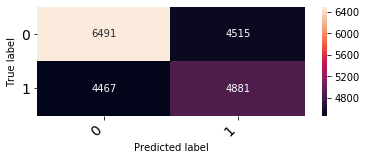

              precision    recall  f1-score   support

           0       0.59      0.59      0.59     11006
           1       0.52      0.52      0.52      9348

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



AttributeError: 'DecisionTreeClassifier' object has no attribute 'decision_function'

In [8]:
# pipeline.score(X_train,y_train)
pipeline = make_pipeline(FeatureEngineering(),DecisionTreeClassifier())
pipeline.fit(X_train,y_train)
pipeline.score(X_train,y_train)
pipeline.score(X_test,y_test)
generate_results(pipeline,X_test,y_test)

In [56]:
feature_engineering = FeatureEngineering()
encoded_training_data = feature_engineering.fit_transform(X_train,y_train)
clf = DecisionTreeClassifier()
clf.fit(encoded_training_data,y_train)
encoded_test_data = feature_engineering.transform(X_test)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [11]:
import shap
explainer = shap.TreeExplainer(clf)

In [42]:
shap_values = explainer.shap_values(X_test,y_test)

In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0])

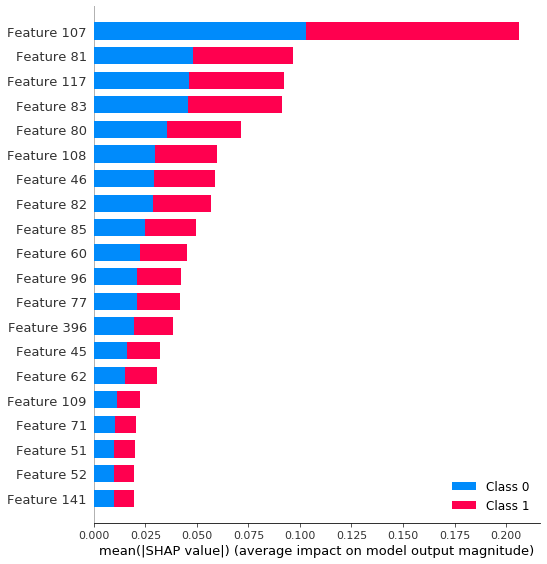

In [51]:
shap.summary_plot(shap_values,encoded_test_data)

In [44]:
print(explainer.expected_value)

[0.5387166511079448, 0.46128334889205524]


In [60]:
print(shap_values[0].shape)

(20354, 397)


In [64]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:100])